In [1]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.patches as patches
from astropy.io import fits
from scipy.interpolate import RectBivariateSpline


In [2]:
def getRadii(catalog, whichRadii):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    elif whichRadii == "dr25":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string');

In [3]:
period_rng = (50, 400)
n_period = 57
rp_rng = (0.75, 2.5)
n_rp = 61


In [4]:

allStars = pd.read_csv("stellarCatalogs/dr25_stellar_berger2019.txt")
bergerGK = pd.read_csv("stellarCatalogs/dr25_stellar_berger2019_clean_GaiaRadCut_GK.txt")
dr25GK = pd.read_csv("stellarCatalogs/dr25_stellar_berger2019_clean_DR25RadCut_GK.txt")

baseDr25Kois = pd.read_csv("GKbaseline_dr25RadCut/koiCatalogs/dr25_GK_PCs.csv")
baseBergerKois = pd.read_csv("GKbaseline_gaiaRadCut/koiCatalogs/dr25_GK_PCs.csv")


In [5]:

# gotta compute the corrected prad for the dr25Kois
baseDr25Kois = pd.merge(baseDr25Kois, allStars[["kepid", "iso_rad", "iso_rad_err1",
                  "iso_rad_err2", "iso_teff","iso_teff_err1","iso_teff_err2"]], 
                        left_on="kepid_x", right_on="kepid", how="inner")
baseBergerKois = pd.merge(baseBergerKois, allStars[["kepid", "iso_rad", "iso_rad_err1",
                  "iso_rad_err2", "iso_teff","iso_teff_err1","iso_teff_err2","teff_DR25","radius_DR25"]], 
                        left_on="kepid_x", right_on="kepid", how="inner")

rEarth = 6356.8 # km
rSun = 695700 # km
baseDr25Kois['corrected_prad'] = baseDr25Kois['koi_ror']*baseDr25Kois['iso_rad']*rSun/rEarth;
baseDr25Kois['corrected_prad_err1'] = np.sqrt(baseDr25Kois['koi_ror_err1']**2*baseDr25Kois['iso_rad']**2
                                        +baseDr25Kois['koi_ror']**2*baseDr25Kois['iso_rad_err1']**2)*rSun/rEarth;
baseDr25Kois['corrected_prad_err2'] = -np.sqrt(baseDr25Kois['koi_ror_err2']**2*baseDr25Kois['iso_rad']**2
                                        +baseDr25Kois['koi_ror']**2*(-baseDr25Kois['iso_rad_err2'])**2)*rSun/rEarth;


periodSelect = (period_rng[0] <= baseDr25Kois.koi_period) & (baseDr25Kois.koi_period <= period_rng[1])

thisRadii = getRadii(baseDr25Kois, "dr25")
select = periodSelect & np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
dr25Kois = baseDr25Kois[select]


periodSelect = (period_rng[0] <= baseBergerKois.koi_period) & (baseBergerKois.koi_period <= period_rng[1])

thisRadii = getRadii(baseBergerKois, "corrected")
select = periodSelect & np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
bergerKois = baseBergerKois[select]


In [6]:
inputgrid = "completenessContours/out_sc0_GKbaseline_DR25RadCut.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]

period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

period = np.linspace(period_rng[0], period_rng[1], n_period)
rp = np.linspace(rp_rng[0], rp_rng[1], n_rp)

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
summedCompleteness = numCompVeInterp(period, rp)

DR25MeanCompleteness = np.mean(np.mean(summedCompleteness/len(kiclist)))
print("DR25MeanCompleteness = " + str(DR25MeanCompleteness))

DR25MeanCompleteness = 0.0025495603750910934


In [7]:
inputgrid = "completenessContours/out_sc0_GKbaseline_gaiaRadCut.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]

period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

period = np.linspace(period_rng[0], period_rng[1], n_period)
rp = np.linspace(rp_rng[0], rp_rng[1], n_rp)

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
summedCompleteness = numCompVeInterp(period, rp)

bergerMeanCompleteness = np.mean(np.mean(summedCompleteness/len(kiclist)))
print("bergerMeanCompleteness = " + str(bergerMeanCompleteness))

bergerMeanCompleteness = 0.00238625431509571


In [8]:
print("there are " + str(len(dr25Kois)) + " DR25 PCs in " + str(len(dr25GK)) 
      + " stars: " + str(float(len(dr25Kois))/len(dr25GK)))
print("implying " + str((float(len(dr25Kois))/len(dr25GK))/DR25MeanCompleteness) + " planets per star")
print("there are " + str(len(bergerKois)) + " Berger2019 PCs in " + str(len(bergerGK)) 
      + " stars: " + str(float(len(bergerKois))/len(bergerGK)))
print("implying " + str((float(len(bergerKois))/len(bergerGK))/bergerMeanCompleteness) + " planets per star")
print("DR25 increase: " + str((float(len(dr25Kois))/len(dr25GK))/(float(len(bergerKois))/len(bergerGK))))


there are 116 DR25 PCs in 71168 stars: 0.00162994604317
implying 0.6393047441001397 planets per star
there are 107 Berger2019 PCs in 67306 stars: 0.00158975425668
implying 0.6662132559054965 planets per star
DR25 increase: 1.02528176057


In [9]:
0.6698493429397818/0.6504874150854538

1.0297652612568753

dr25KOIsNotInBerger: 24 left the box by getting too large


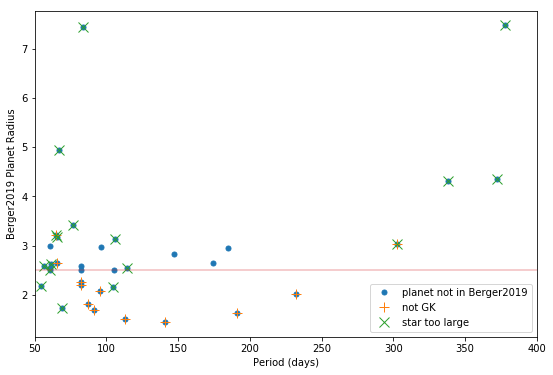

In [10]:
dr25KOIsNotInBerger = dr25Kois[~dr25Kois.kepid_x.isin(bergerKois.kepid_x)]
notGK = (dr25KOIsNotInBerger.iso_teff < 3900) | (dr25KOIsNotInBerger.iso_teff > 6000)
tooBig = (dr25KOIsNotInBerger.iso_rad > 1.35)

plt.figure(figsize=(9,6));
plt.plot(dr25KOIsNotInBerger.koi_period, dr25KOIsNotInBerger.corrected_prad, '.', ms=10)
plt.plot(dr25KOIsNotInBerger[notGK].koi_period, dr25KOIsNotInBerger[notGK].corrected_prad, '+', ms=10)
plt.plot(dr25KOIsNotInBerger[tooBig].koi_period, dr25KOIsNotInBerger[tooBig].corrected_prad, 'x', ms=10)
plt.legend(("planet not in Berger2019", "not GK", "star too large"))
plt.plot([50,400], [2.5, 2.5], alpha=0.3)
plt.xlim(50,400)
plt.xlabel("Period (days)")
plt.ylabel("Berger2019 Planet Radius")
print("dr25KOIsNotInBerger: " + str(np.sum(dr25KOIsNotInBerger.corrected_prad>2.5)) 
      + " left the box by getting too large")

bergerKOIsNotInDr25: 19 left the box by getting too large


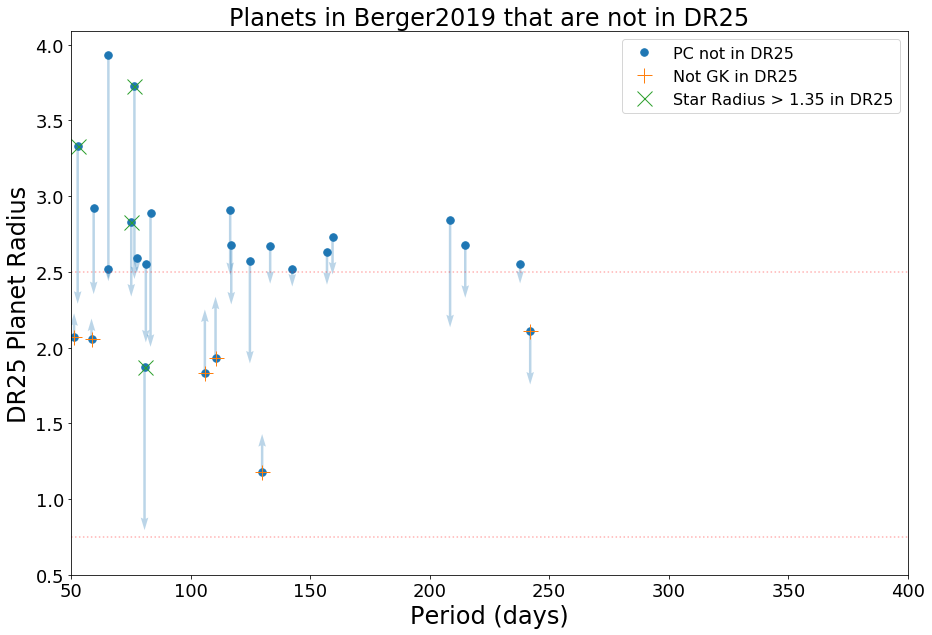

In [11]:
bergerKOIsNotInDr25 = bergerKois[~bergerKois.kepid_x.isin(dr25Kois.kepid_x)]
notGK = (bergerKOIsNotInDr25.teff_DR25 < 3900) | (bergerKOIsNotInDr25.teff_DR25 > 6000)
tooBig = (bergerKOIsNotInDr25.radius_DR25 > 1.35)
dRad = bergerKOIsNotInDr25.koi_prad - bergerKOIsNotInDr25.corrected_prad

markerSize=15
plt.figure(figsize=(15,10));
p = plt.plot(bergerKOIsNotInDr25.koi_period, bergerKOIsNotInDr25.koi_prad, '.', ms=markerSize)
plt.plot(bergerKOIsNotInDr25[notGK].koi_period, bergerKOIsNotInDr25[notGK].koi_prad, '+', ms=markerSize)
plt.plot(bergerKOIsNotInDr25[tooBig].koi_period, bergerKOIsNotInDr25[tooBig].koi_prad, 'x', ms=markerSize)
plt.quiver(bergerKOIsNotInDr25.koi_period, bergerKOIsNotInDr25.koi_prad, np.zeros(dRad.shape), -dRad, 
           angles='xy', scale_units='xy', scale=1, color = p[0].get_color(), width=0.003, alpha=0.3)
plt.legend(("PC not in DR25", "Not GK in DR25", "Star Radius > 1.35 in DR25"), fontsize = 16)
plt.plot([50,400], [rp_rng[0], rp_rng[0]], 'r:', alpha=0.3)
plt.plot([50,400], [rp_rng[1], rp_rng[1]], 'r:', alpha=0.3)
plt.xlim(50,400)
yl = plt.ylim()
plt.ylim(0.5,yl[1])
plt.tick_params(labelsize = 18)
plt.xlabel("Period (days)", fontsize = 24)
plt.ylabel("DR25 Planet Radius", fontsize = 24)

plt.savefig("PCRadChangeBerger2019.pdf",bbox_inches='tight')

plt.title("Planets in Berger2019 that are not in DR25", fontsize = 24)

print("bergerKOIsNotInDr25: " + str(np.sum(bergerKOIsNotInDr25.koi_prad>2.5)) 
      + " left the box by getting too large")

dr25KOIsNotInBerger: 24 left the box by getting too large


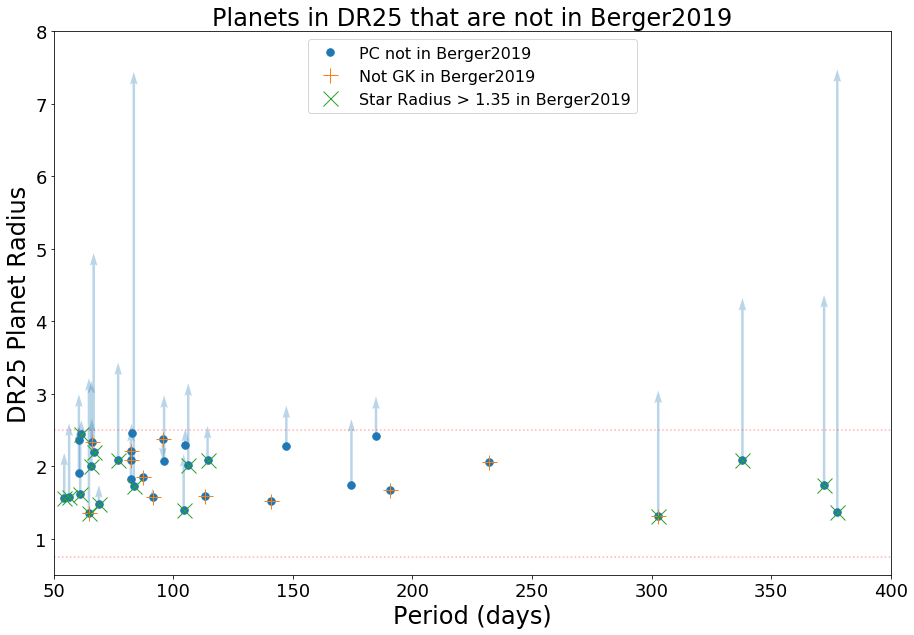

In [12]:
dr25KOIsNotInBerger = dr25Kois[~dr25Kois.kepid_x.isin(bergerKois.kepid_x)]
notGK = (dr25KOIsNotInBerger.iso_teff < 3900) | (dr25KOIsNotInBerger.iso_teff > 6000)
tooBig = (dr25KOIsNotInBerger.iso_rad > 1.35)
dRad = dr25KOIsNotInBerger.koi_prad - dr25KOIsNotInBerger.corrected_prad

markerSize=15
plt.figure(figsize=(15,10));
p = plt.plot(dr25KOIsNotInBerger.koi_period, dr25KOIsNotInBerger.koi_prad, '.', ms=markerSize)
plt.plot(dr25KOIsNotInBerger[notGK].koi_period, dr25KOIsNotInBerger[notGK].koi_prad, '+', ms=markerSize)
plt.plot(dr25KOIsNotInBerger[tooBig].koi_period, dr25KOIsNotInBerger[tooBig].koi_prad, 'x', ms=markerSize)
plt.quiver(dr25KOIsNotInBerger.koi_period, dr25KOIsNotInBerger.koi_prad, np.zeros(dRad.shape), -dRad, 
           angles='xy', scale_units='xy', scale=1, color = p[0].get_color(), width=0.003, alpha=0.3)
plt.legend(("PC not in Berger2019", "Not GK in Berger2019", "Star Radius > 1.35 in Berger2019"), 
           loc='upper center', fontsize = 16)
plt.plot([50,400], [rp_rng[0], rp_rng[0]], 'r:', alpha=0.3)
plt.plot([50,400], [rp_rng[1], rp_rng[1]], 'r:', alpha=0.3)
plt.xlim(50,400)
plt.ylim(0.5,8.0)
plt.tick_params(labelsize = 18)
plt.xlabel("Period (days)", fontsize = 24)
plt.ylabel("DR25 Planet Radius", fontsize = 24)

plt.savefig("PCRadChangeDR25.pdf",bbox_inches='tight')

plt.title("Planets in DR25 that are not in Berger2019", fontsize = 24)
print("dr25KOIsNotInBerger: " + str(np.sum(dr25KOIsNotInBerger.corrected_prad>2.5)) 
      + " left the box by getting too large")

[ 50.         166.66666667 283.33333333 400.        ]
dr25KOIsInBerger: 0 left the box by getting too large


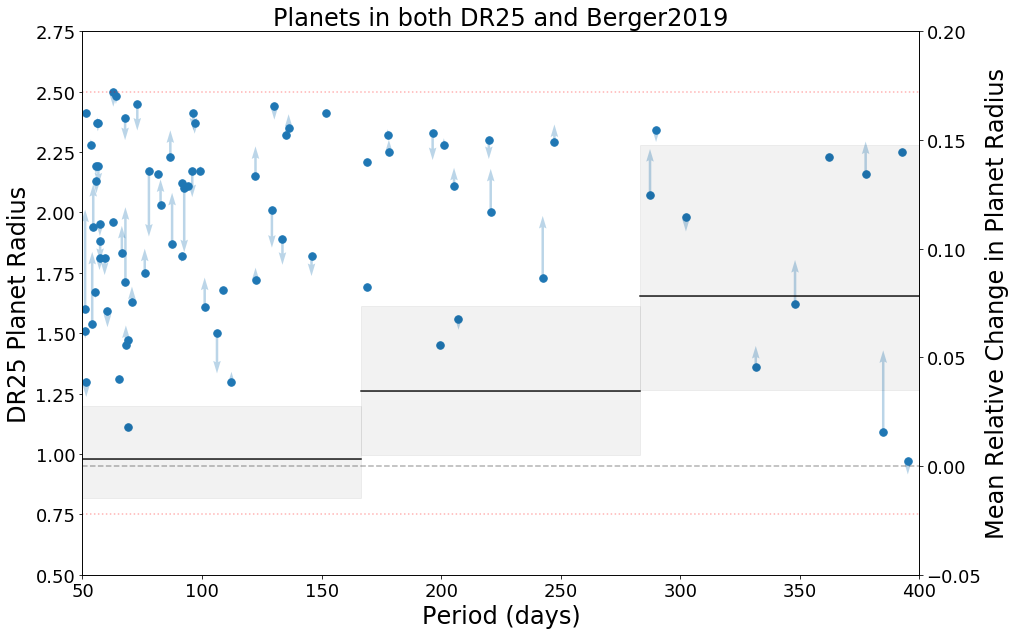

In [30]:
dr25KOIsInBerger = dr25Kois[dr25Kois.kepid_x.isin(bergerKois.kepid_x)]
dRad = (dr25KOIsInBerger.corrected_prad - dr25KOIsInBerger.koi_prad)/dr25KOIsInBerger.koi_prad
dRad_err1 = (np.sqrt(dr25KOIsInBerger.corrected_prad_err1**2 + dr25KOIsInBerger.koi_prad_err1**2))/dr25KOIsInBerger.koi_prad
dRad_err2 = (np.sqrt(dr25KOIsInBerger.corrected_prad_err2**2 + dr25KOIsInBerger.koi_prad_err2**2))/dr25KOIsInBerger.koi_prad
radBins = np.linspace(50, 400, 4)
print(radBins)
meanDrad = np.zeros(len(radBins)-1)
meanDrad_err1 = np.zeros(len(radBins)-1)
meanDrad_err2 = np.zeros(len(radBins)-1)
for i in range(len(meanDrad)):
    s = (dr25KOIsInBerger.koi_period>=radBins[i])&(dr25KOIsInBerger.koi_period<radBins[i+1]);
    meanDrad[i] = np.mean(dRad[s])
    meanDrad_err1[i] = np.sqrt(np.sum(dRad_err1[s]**2))/np.sum(s);
    meanDrad_err2[i] = np.sqrt(np.sum(dRad_err2[s]**2))/np.sum(s);

markerSize=15
fig, ax1 = plt.subplots(figsize=(15,10));
p = ax1.plot(dr25KOIsInBerger.koi_period, dr25KOIsInBerger.koi_prad, '.', markerSize=markerSize)
ax1.quiver(dr25KOIsInBerger.koi_period, dr25KOIsInBerger.koi_prad, np.zeros(dRad.shape), dRad, 
           angles='xy', scale_units='xy', color = p[0].get_color(), scale=1, width=0.003, alpha=0.3)
ax1.plot([50,400], [rp_rng[0], rp_rng[0]], 'r:', alpha=0.3)
ax1.plot([50,400], [rp_rng[1], rp_rng[1]], 'r:', alpha=0.3)
ax1.set_xlim(50,400)
ax1.set_ylim(0.5,2.75)
ax1.set_xlabel("Period (days)", fontsize = 24)
ax1.set_ylabel("DR25 Planet Radius", fontsize = 24)
ax1.tick_params(labelsize = 18)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
for i in range(len(meanDrad)):
    plt.fill_between([radBins[i],radBins[i+1]], meanDrad[i], meanDrad[i]+meanDrad_err1[i], 
                     color = 'k', alpha=0.05)
    plt.fill_between([radBins[i],radBins[i+1]], meanDrad[i], meanDrad[i]-meanDrad_err2[i], 
                     color = 'k', alpha=0.05)
    ax2.plot([radBins[i],radBins[i+1]], [meanDrad[i],meanDrad[i]], c='k', alpha=0.9)

ax2.plot([50,400], [0,0], 'k--', alpha=0.3)
ax2.set_ylim(-0.05, 0.2)
ax2.set_ylabel("Mean Relative Change in Planet Radius", color='k', fontsize = 24)
ax2.tick_params(labelsize = 18)

plt.savefig("PCRadChangeBoth.pdf",bbox_inches='tight')

plt.title("Planets in both DR25 and Berger2019", fontsize = 24)

print("dr25KOIsInBerger: " + str(np.sum(dr25KOIsInBerger.corrected_prad>2.5)) 
      + " left the box by getting too large")

In [14]:
meanDrad

array([0.00347009, 0.03459277, 0.078034  ])

In [15]:
meanDrad_err2

array([0.01827284, 0.02939649, 0.04303758])

dr25KOIsNotInBerger: 24 left the box by getting too large


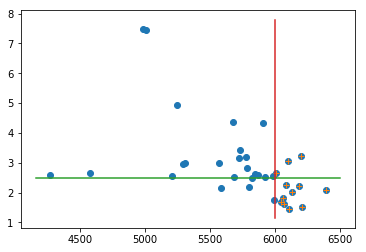

In [16]:
dr25KOIsNotInBerger = dr25Kois[~dr25Kois.kepid_x.isin(bergerKois.kepid_x)]
notGK = (dr25KOIsNotInBerger.iso_teff < 3900) | (dr25KOIsNotInBerger.iso_teff > 6000)

plt.plot(dr25KOIsNotInBerger.iso_teff, dr25KOIsNotInBerger.corrected_prad, 'o')
plt.plot(dr25KOIsNotInBerger[notGK].iso_teff, dr25KOIsNotInBerger[notGK].corrected_prad, '+')
xl = plt.xlim();
yl = plt.ylim();
plt.plot(xl, [2.5, 2.5])
plt.plot([6000,6000], yl)
print("dr25KOIsNotInBerger: " + str(np.sum(dr25KOIsNotInBerger.corrected_prad>2.5)) 
      + " left the box by getting too large")

bergerKOIsNotInDr25: 19 left the box by getting too large


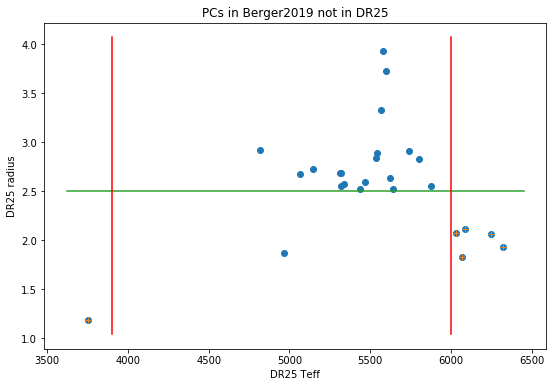

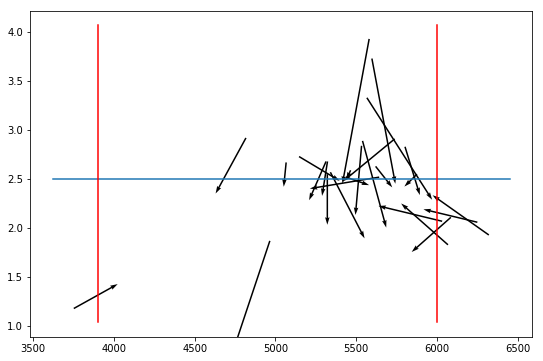

In [17]:
bergerKOIsNotInDr25 = bergerKois[~bergerKois.kepid_x.isin(dr25Kois.kepid_x)]
notGK = (bergerKOIsNotInDr25.teff_DR25 < 3900) | (bergerKOIsNotInDr25.teff_DR25 > 6000)

plt.figure(figsize=(9,6));
plt.plot(bergerKOIsNotInDr25.teff_DR25, bergerKOIsNotInDr25.koi_prad, 'o')
plt.plot(bergerKOIsNotInDr25[notGK].teff_DR25, bergerKOIsNotInDr25[notGK].koi_prad, '+')
xl = plt.xlim();
yl = plt.ylim();
plt.plot(xl, [2.5, 2.5])
plt.plot([6000,6000], yl, 'r')
plt.plot([3900,3900], yl, 'r')
plt.xlabel("DR25 Teff")
plt.ylabel("DR25 radius")
plt.title("PCs in Berger2019 not in DR25")

print("bergerKOIsNotInDr25: " + str(np.sum(bergerKOIsNotInDr25.koi_prad>2.5)) 
      + " left the box by getting too large")

plt.figure(figsize=(9,6));
dTeff = bergerKOIsNotInDr25.teff_DR25 - bergerKOIsNotInDr25.iso_teff
dRad = bergerKOIsNotInDr25.koi_prad - bergerKOIsNotInDr25.corrected_prad

plt.quiver(bergerKOIsNotInDr25.teff_DR25, bergerKOIsNotInDr25.koi_prad, -dTeff, -dRad, 
           angles='xy', scale_units='xy', scale=1, width=0.003)
plt.plot(xl, [2.5, 2.5])
plt.plot([6000,6000], yl, 'r')
plt.plot([3900,3900], yl, 'r')


dr25KOIsNotInBerger: 24 left the box by getting too large


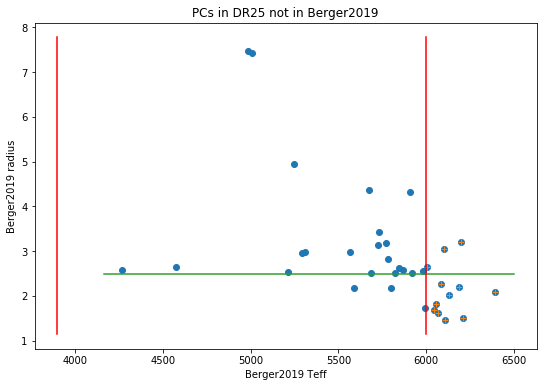

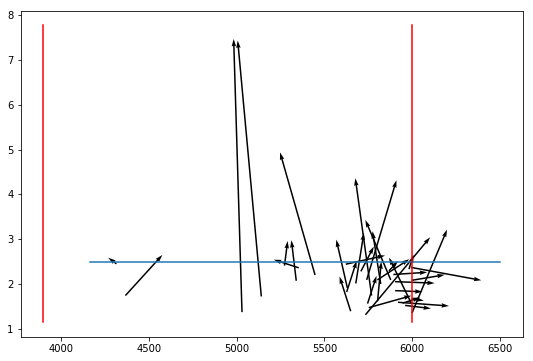

In [18]:
dr25KOIsNotInBerger = dr25Kois[~dr25Kois.kepid_x.isin(bergerKois.kepid_x)]
notGK = (dr25KOIsNotInBerger.iso_teff < 3900) | (dr25KOIsNotInBerger.iso_teff > 6000)

plt.figure(figsize=(9,6));
plt.plot(dr25KOIsNotInBerger.iso_teff, dr25KOIsNotInBerger.corrected_prad, 'o')
plt.plot(dr25KOIsNotInBerger[notGK].iso_teff, dr25KOIsNotInBerger[notGK].corrected_prad, '+')
xl = plt.xlim();
yl = plt.ylim();
plt.plot(xl, [2.5, 2.5])
plt.plot([6000,6000], yl, 'r')
plt.plot([3900,3900], yl, 'r')
plt.xlabel("Berger2019 Teff")
plt.ylabel("Berger2019 radius")
plt.title("PCs in DR25 not in Berger2019")

print("dr25KOIsNotInBerger: " + str(np.sum(dr25KOIsNotInBerger.corrected_prad>2.5)) 
      + " left the box by getting too large")

plt.figure(figsize=(9,6));
dTeff = dr25KOIsNotInBerger.iso_teff - dr25KOIsNotInBerger.teff
dRad = dr25KOIsNotInBerger.corrected_prad - dr25KOIsNotInBerger.koi_prad

plt.quiver(dr25KOIsNotInBerger.teff, dr25KOIsNotInBerger.koi_prad, dTeff, dRad, 
           angles='xy', scale_units='xy', scale=1, width=0.003)
plt.plot(xl, [2.5, 2.5])
plt.plot([6000,6000], yl, 'r')
plt.plot([3900,3900], yl, 'r')


Text(0.5,1,'PCs in Berger2019 not in DR25')

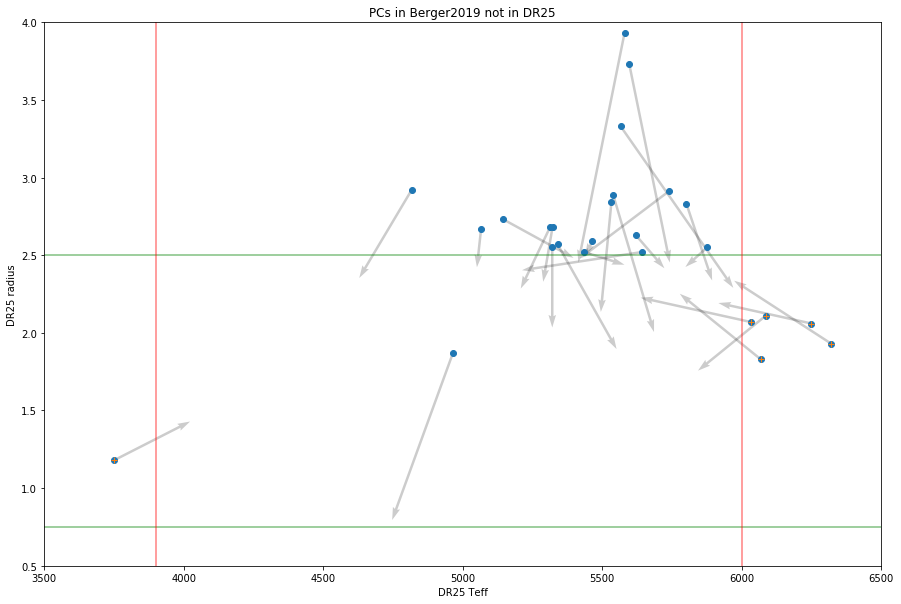

In [19]:
bergerKOIsNotInDr25 = bergerKois[~bergerKois.kepid_x.isin(dr25Kois.kepid_x)]
notGK = (bergerKOIsNotInDr25.teff_DR25 < 3900) | (bergerKOIsNotInDr25.teff_DR25 > 6000)
dTeff = bergerKOIsNotInDr25.teff_DR25 - bergerKOIsNotInDr25.iso_teff
dRad = bergerKOIsNotInDr25.koi_prad - bergerKOIsNotInDr25.corrected_prad

plt.figure(figsize=(15,10));
plt.plot(bergerKOIsNotInDr25.teff_DR25, bergerKOIsNotInDr25.koi_prad, 'o')
plt.plot(bergerKOIsNotInDr25[notGK].teff_DR25, bergerKOIsNotInDr25[notGK].koi_prad, '+')
plt.quiver(bergerKOIsNotInDr25.teff_DR25, bergerKOIsNotInDr25.koi_prad, -dTeff, -dRad, 
           angles='xy', scale_units='xy', scale=1, width=0.003, alpha=0.2)
plt.xlim(3500,6500);
plt.ylim(0.5,4.0);
xl = plt.xlim();
yl = plt.ylim();
plt.ylim(0.5,yl[1])
plt.plot(xl, [rp_rng[1], rp_rng[1]], 'g', alpha=0.5)
plt.plot(xl, [rp_rng[0], rp_rng[0]], 'g', alpha=0.5)
plt.plot([6000,6000], yl, 'r', alpha=0.5)
plt.plot([3900,3900], yl, 'r', alpha=0.5)
plt.xlabel("DR25 Teff")
plt.ylabel("DR25 radius")
plt.title("PCs in Berger2019 not in DR25")



In [20]:
bergerKOIsNotInDr25[(bergerKOIsNotInDr25.teff_DR25>3900)&(bergerKOIsNotInDr25.teff_DR25<6000)
                    &(bergerKOIsNotInDr25.koi_prad<2.5)].kepid_x

1692    3852872
Name: kepid_x, dtype: int64

the one planet not moved out of the Teff-Radius box is missing from DR25 because its star's radius is 1.708, so it was removed in the radius cut.

In [21]:
pd.set_option('display.max_columns', None)
allStars[allStars.kepid==3852872]

,kepid,tm_designation,teff,teff_err1,teff_err2,logg,logg_err1,logg_err2,feh,feh_err1,feh_err2,mass,mass_err1,mass_err2,radius,radius_err1,radius_err2,dens,dens_err1,dens_err2,prov_sec,kepmag,limbdark_coeff1,limbdark_coeff2,limbdark_coeff3,limbdark_coeff4,dist,dist_err1,dist_err2,nconfp,nkoi,ntce,datalink_dvr,st_delivname,st_vet_date_str,ra,dec,st_quarters,teff_prov,logg_prov,feh_prov,jmag,jmag_err,hmag,hmag_err,kmag,kmag_err,dutycycle,dataspan,mesthres01p5,mesthres02p0,mesthres02p5,mesthres03p0,mesthres03p5,mesthres04p5,mesthres05p0,mesthres06p0,mesthres07p5,mesthres09p0,mesthres10p5,mesthres12p0,mesthres12p5,mesthres15p0,rrmscdpp01p5,rrmscdpp02p0,rrmscdpp02p5,rrmscdpp03p0,rrmscdpp03p5,rrmscdpp04p5,rrmscdpp05p0,rrmscdpp06p0,rrmscdpp07p5,rrmscdpp09p0,rrmscdpp10p5,rrmscdpp12p0,rrmscdpp12p5,rrmscdpp15p0,av,av_err1,av_err2,dutycycle_post,dataspan_post,timeout01p5,timeout02p0,timeout02p5,timeout03p0,timeout03p5,timeout04p5,timeout05p0,timeout06p0,timeout07p5,timeout09p0,timeout10p5,timeout12p0,timeout12p5,timeout15p0,timeoutsumry,cdppslplong,cdppslpshrt,KIC,Gaia,Teff,e_Teff,D,E_D,e_D,R*,E_R*,e_R*,AV,Evol,Bin,dist_DR25,dist_DR25_err1,dist_DR25_err2,radius_DR25,radius_DR25_err1,radius_DR25_err2,RUWE,parallax,parallax_err,iso_avs,iso_avs_err1,iso_avs_err2,iso_feh,iso_feh_err1,iso_feh_err2,iso_gof,iso_logg,iso_logg_err1,iso_logg_err2,iso_mass,iso_mass_err1,iso_mass_err2,iso_rad,iso_rad_err1,iso_rad_err2,iso_rho,iso_rho_err1,iso_rho_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_kepid,teff_DR25,teff_DR25_err1,teff_DR25_err2,logg_DR25,logg_DR25_err1,logg_DR25_err2,feh_DR25,feh_DR25_err1,feh_DR25_err2,limbdark_coeff1_DR25,limbdark_coeff2_DR25,limbdark_coeff3_DR25,limbdark_coeff4_DR25
53417,3852872,2MASS J19283330+3856295,4747.208785,78.196765,70.208988,4.587537,0.022561,0.024929,-0.019296,0.106498,0.105268,0.973,0.211,-0.141,0.724251,0.011906,0.012097,0.275,2.168,-0.19,DSEP,13.026,0.743594,-0.851796,1.576532,-0.622649,215.979,0.685,-0.683,0,1,1,003/003852/003852872/dv/kplr003852872-20160209...,q1_q17_dr25_stellar,2017-03-23,292.13876,38.94154,11111111111111111,PHO1,KIC0,KIC0,11.513,0.022,10.999,0.019,10.911,0.019,0.8736,1458.931,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,89.237,81.876,79.065,75.181,73.337,69.592,68.492,66.904,65.702,65.16,65.842,66.23,66.667,69.16,0.316,0.12,-0.18,0.8683,1458.931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.06903,-0.39845,3852872,2052724922724196608,4968,174,215.979,0.685,0.683,0.706,0.052,0.047,0.084,0,0,515.35,270.79,-270.79,1.708,1.067,-0.873,0.997127,0.00463,0.000015,0.0,0.0,-0.0,-0.019296,0.106498,-0.105268,1.0,4.587537,0.022561,-0.024929,0.743012,0.032939,-0.03595,0.724251,0.011906,-0.012097,1.941899,0.122783,-0.123312,4747.208785,78.196765,-70.208988,3852872,4965,164.0,-134.0,3.961,0.605,-0.326,0.42,0.05,-0.3,0.7331,-0.7441,1.4086,-0.5556


In [22]:
dr25KOIsNotInBerger[(dr25KOIsNotInBerger.iso_teff>3900)&(dr25KOIsNotInBerger.iso_teff<6000)
                    &(dr25KOIsNotInBerger.corrected_prad<2.5)].kepid_x

646     10453588
718      4247991
1243     9838468
Name: kepid_x, dtype: int64

In [23]:
allStars[allStars.kepid==10453588]

,kepid,tm_designation,teff,teff_err1,teff_err2,logg,logg_err1,logg_err2,feh,feh_err1,feh_err2,mass,mass_err1,mass_err2,radius,radius_err1,radius_err2,dens,dens_err1,dens_err2,prov_sec,kepmag,limbdark_coeff1,limbdark_coeff2,limbdark_coeff3,limbdark_coeff4,dist,dist_err1,dist_err2,nconfp,nkoi,ntce,datalink_dvr,st_delivname,st_vet_date_str,ra,dec,st_quarters,teff_prov,logg_prov,feh_prov,jmag,jmag_err,hmag,hmag_err,kmag,kmag_err,dutycycle,dataspan,mesthres01p5,mesthres02p0,mesthres02p5,mesthres03p0,mesthres03p5,mesthres04p5,mesthres05p0,mesthres06p0,mesthres07p5,mesthres09p0,mesthres10p5,mesthres12p0,mesthres12p5,mesthres15p0,rrmscdpp01p5,rrmscdpp02p0,rrmscdpp02p5,rrmscdpp03p0,rrmscdpp03p5,rrmscdpp04p5,rrmscdpp05p0,rrmscdpp06p0,rrmscdpp07p5,rrmscdpp09p0,rrmscdpp10p5,rrmscdpp12p0,rrmscdpp12p5,rrmscdpp15p0,av,av_err1,av_err2,dutycycle_post,dataspan_post,timeout01p5,timeout02p0,timeout02p5,timeout03p0,timeout03p5,timeout04p5,timeout05p0,timeout06p0,timeout07p5,timeout09p0,timeout10p5,timeout12p0,timeout12p5,timeout15p0,timeoutsumry,cdppslplong,cdppslpshrt,KIC,Gaia,Teff,e_Teff,D,E_D,e_D,R*,E_R*,e_R*,AV,Evol,Bin,dist_DR25,dist_DR25_err1,dist_DR25_err2,radius_DR25,radius_DR25_err1,radius_DR25_err2,RUWE,parallax,parallax_err,iso_avs,iso_avs_err1,iso_avs_err2,iso_feh,iso_feh_err1,iso_feh_err2,iso_gof,iso_logg,iso_logg_err1,iso_logg_err2,iso_mass,iso_mass_err1,iso_mass_err2,iso_rad,iso_rad_err1,iso_rad_err2,iso_rho,iso_rho_err1,iso_rho_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_kepid,teff_DR25,teff_DR25_err1,teff_DR25_err2,logg_DR25,logg_DR25_err1,logg_DR25_err2,feh_DR25,feh_DR25_err1,feh_DR25_err2,limbdark_coeff1_DR25,limbdark_coeff2_DR25,limbdark_coeff3_DR25,limbdark_coeff4_DR25
8730,10453588,2MASS J18553242+4738139,5995.587164,119.023202,117.026015,4.115425,0.043952,0.040144,-0.301143,0.144894,0.150159,0.863,0.073,-0.042,1.444948,0.032075,0.031881,0.6666,0.7013,-0.2114,DSEP,12.464,0.313426,0.762541,-0.486551,0.111154,514.37,5.663,-5.555,1,1,1,010/010453/010453588/dv/kplr010453588-20160209...,q1_q17_dr25_stellar,2017-03-23,283.8851,47.637218,11111111111111111,SPE59,SPE59,SPE59,11.387,0.022,11.065,0.018,11.016,0.017,0.8734,1458.931,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,60.95,54.114,50.771,46.964,44.545,40.333,38.507,35.724,32.709,30.261,28.746,27.372,27.024,25.132,0.214,0.022,-0.036,0.8628,1458.931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.37326,-0.65083,10453588,2131628282308860288,5711,114,514.37,5.663,5.555,1.491,0.064,0.061,0.09,1,0,414.2,65.72,-90.37,1.222,0.202,-0.27,0.963852,0.001945,0.000021,0.154871,0.0,-0.0,-0.301143,0.144894,-0.150159,0.999999,4.115425,0.043952,-0.040144,0.998476,0.0806,-0.066237,1.444948,0.032075,-0.031881,0.328207,0.040379,-0.034108,5995.587164,119.023202,-117.026015,10453588,5753,115.0,-92.0,4.2,0.201,-0.108,-0.28,0.15,-0.1,0.3817,0.463,-0.042,-0.0786


In [24]:
allStars[allStars.kepid==4247991]

,kepid,tm_designation,teff,teff_err1,teff_err2,logg,logg_err1,logg_err2,feh,feh_err1,feh_err2,mass,mass_err1,mass_err2,radius,radius_err1,radius_err2,dens,dens_err1,dens_err2,prov_sec,kepmag,limbdark_coeff1,limbdark_coeff2,limbdark_coeff3,limbdark_coeff4,dist,dist_err1,dist_err2,nconfp,nkoi,ntce,datalink_dvr,st_delivname,st_vet_date_str,ra,dec,st_quarters,teff_prov,logg_prov,feh_prov,jmag,jmag_err,hmag,hmag_err,kmag,kmag_err,dutycycle,dataspan,mesthres01p5,mesthres02p0,mesthres02p5,mesthres03p0,mesthres03p5,mesthres04p5,mesthres05p0,mesthres06p0,mesthres07p5,mesthres09p0,mesthres10p5,mesthres12p0,mesthres12p5,mesthres15p0,rrmscdpp01p5,rrmscdpp02p0,rrmscdpp02p5,rrmscdpp03p0,rrmscdpp03p5,rrmscdpp04p5,rrmscdpp05p0,rrmscdpp06p0,rrmscdpp07p5,rrmscdpp09p0,rrmscdpp10p5,rrmscdpp12p0,rrmscdpp12p5,rrmscdpp15p0,av,av_err1,av_err2,dutycycle_post,dataspan_post,timeout01p5,timeout02p0,timeout02p5,timeout03p0,timeout03p5,timeout04p5,timeout05p0,timeout06p0,timeout07p5,timeout09p0,timeout10p5,timeout12p0,timeout12p5,timeout15p0,timeoutsumry,cdppslplong,cdppslpshrt,KIC,Gaia,Teff,e_Teff,D,E_D,e_D,R*,E_R*,e_R*,AV,Evol,Bin,dist_DR25,dist_DR25_err1,dist_DR25_err2,radius_DR25,radius_DR25_err1,radius_DR25_err2,RUWE,parallax,parallax_err,iso_avs,iso_avs_err1,iso_avs_err2,iso_feh,iso_feh_err1,iso_feh_err2,iso_gof,iso_logg,iso_logg_err1,iso_logg_err2,iso_mass,iso_mass_err1,iso_mass_err2,iso_rad,iso_rad_err1,iso_rad_err2,iso_rho,iso_rho_err1,iso_rho_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_kepid,teff_DR25,teff_DR25_err1,teff_DR25_err2,logg_DR25,logg_DR25_err1,logg_DR25_err2,feh_DR25,feh_DR25_err1,feh_DR25_err2,limbdark_coeff1_DR25,limbdark_coeff2_DR25,limbdark_coeff3_DR25,limbdark_coeff4_DR25
59314,4247991,2MASS J19085788+3919579,5586.538902,106.942167,101.854019,4.157384,0.041041,0.038689,0.035406,0.164632,0.131226,0.971,0.046,-0.08,1.350867,0.030316,0.029676,2.075,0.2123,-0.7046,DSEP,12.57,0.539589,-0.074976,0.636247,-0.336067,459.157,4.826,-4.74,1,3,1,004/004247/004247991/dv/kplr004247991-20160209...,q1_q17_dr25_stellar,2017-03-23,287.24118,39.33276,10111011101110111,SPE59,SPE59,SPE59,11.386,0.023,11.039,0.022,10.981,0.017,0.6427,1458.931,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,66.664,61.608,59.581,56.791,55.55,54.05,53.739,53.663,54.423,55.844,58.251,60.547,61.324,65.513,0.171,0.028,-0.012,0.6396,1458.931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.26867,-0.33533,4247991,2100408508633587712,5657,113,459.157,4.826,4.74,1.367,0.059,0.056,0.31,1,0,293.22,43.52,-17.41,0.87,0.124,-0.039,0.952096,0.002179,0.000023,0.064864,0.005549,-0.002137,0.035406,0.164632,-0.131226,1.0,4.157384,0.041041,-0.038689,0.963729,0.069489,-0.062463,1.350867,0.030316,-0.029676,0.386352,0.045896,-0.038793,5586.538902,106.942167,-101.854019,4247991,5650,112.0,-112.0,4.546,0.021,-0.119,0.02,0.15,-0.15,0.5436,-0.0724,0.6261,-0.3357


Text(0.5,1,'PCs in Berger2019 not in DR25')

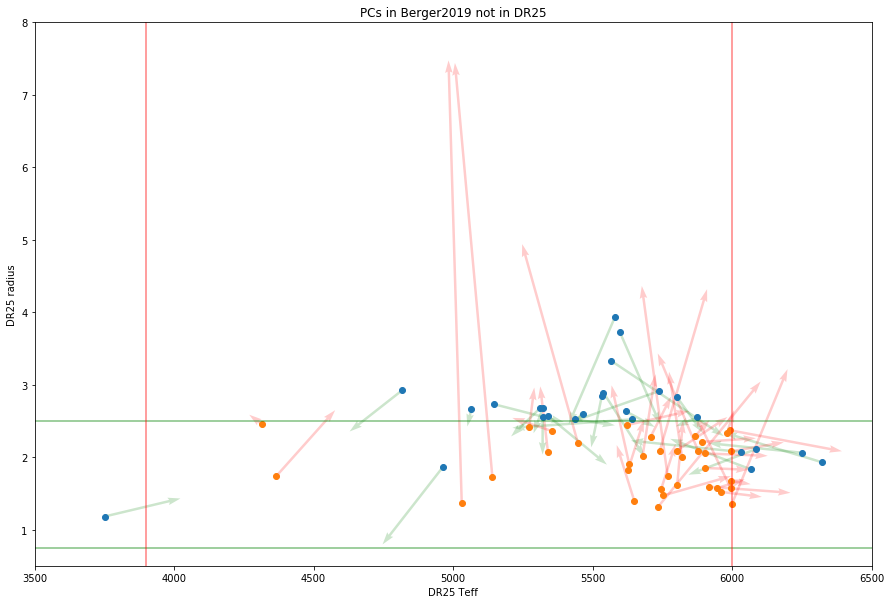

In [25]:
bergerKOIsNotInDr25 = bergerKois[~bergerKois.kepid_x.isin(dr25Kois.kepid_x)]
dTeff = bergerKOIsNotInDr25.teff_DR25 - bergerKOIsNotInDr25.iso_teff
dRad = bergerKOIsNotInDr25.koi_prad - bergerKOIsNotInDr25.corrected_prad
dTeff2 = dr25KOIsNotInBerger.iso_teff - dr25KOIsNotInBerger.teff
dRad2 = dr25KOIsNotInBerger.corrected_prad - dr25KOIsNotInBerger.koi_prad

plt.figure(figsize=(15,10));
plt.plot(bergerKOIsNotInDr25.teff_DR25, bergerKOIsNotInDr25.koi_prad, 'o')
plt.plot(dr25KOIsNotInBerger.teff, dr25KOIsNotInBerger.koi_prad, 'o')
plt.quiver(bergerKOIsNotInDr25.teff_DR25, bergerKOIsNotInDr25.koi_prad, -dTeff, -dRad, 
           angles='xy', scale_units='xy', color='g', scale=1, width=0.003, alpha=0.2)
plt.quiver(dr25KOIsNotInBerger.teff, dr25KOIsNotInBerger.koi_prad, dTeff2, dRad2, 
           angles='xy', scale_units='xy', color='r', scale=1, width=0.003, alpha=0.2)
plt.xlim(3500,6500);
plt.ylim(0.5,8.0);
xl = plt.xlim();
yl = plt.ylim();
plt.ylim(0.5,yl[1])
plt.plot(xl, [rp_rng[1], rp_rng[1]], 'g', alpha=0.5)
plt.plot(xl, [rp_rng[0], rp_rng[0]], 'g', alpha=0.5)
plt.plot([6000,6000], yl, 'r', alpha=0.5)
plt.plot([3900,3900], yl, 'r', alpha=0.5)
plt.xlabel("DR25 Teff")
plt.ylabel("DR25 radius")
plt.title("PCs in Berger2019 not in DR25")



In [26]:
dRad

389    -0.156410
728     1.476107
797     1.277211
879     0.116727
882    -0.131994
885     0.430852
976     0.515701
1055    0.081536
1104    0.566918
1120    0.674665
1142    0.351309
1169    0.247401
1175    0.214406
1217    0.884827
1220    0.705621
1246    0.248033
1274   -0.405691
1316   -0.421744
1338    0.492999
1447    0.094577
1513    0.395142
1573    0.126144
1661   -0.249029
1671    1.040734
1692    1.074988
1809    0.353579
dtype: float64